# Notebook on self-knowledge in commentaries on book 3

This notebook contains the quantitative analyses of the doctrinal network for the chapter on book 3.


# Analysis

## Setup

In [1]:
import pandas as pd
import seaborn as sns; sns.set()
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from os import path

from utilities import save_table, print_figure_inclusion, build_matrix

from py2neo import Graph
graph = Graph('https://hobby-ijiahihliahcgbkepnpggmbl.dbs.graphenedb.com:24780/db/data/',
              user='remote',
              password="b.WKJhDFo38DGT.XBFHkuTL7R6BEEgw")

sns.set_context("paper", font_scale=1.5)

#pd.set_option('display.max_colwidth', -1)

In [2]:
author_names = graph.run('MATCH (n:Author)--(:Text)--(:Question)--(:Instance)--(:DissertationPart {chapter:3}) RETURN distinct n.name ORDER BY n.name asc').to_data_frame()['n.name']

In [3]:
author_names

0              Anonymus Assisi
1               Anonymus Bazan
2            Anonymus Digby 55
3    Anonymus Vat. Lat. 2170 2
4            Henric de la Wyle
5                John Dinsdale
6               John of Jandun
7              Radulphus Brito
8             Siger of Brabant
9           Simon of Faversham
Name: n.name, dtype: object

## Quantities

In [4]:
# Number of doctrines
q = ("MATCH (d:Doctrine)--(:Instance)--(:DissertationPart {chapter:3}) RETURN count(distinct d)")
total_doctrines = graph.run(q).evaluate()

# Number of instances
q = ("MATCH (i:Instance)--(:DissertationPart {chapter:3}) RETURN count(distinct i)")
total_instances = graph.run(q).evaluate()

# Number of conclusion doctrines
q = ("MATCH (:DissertationPart {chapter:3})--(i:Instance {type:'Conclusion'})-[:OF]->(d:Doctrine) "
     "RETURN count(distinct d)")
conclusion_doctrines = graph.run(q).evaluate()

# Number of conclusion instances
q = ("MATCH (i:Instance)--(:DissertationPart {chapter:3}) RETURN count(distinct i)")
conclusion_instances =  graph.run(q).evaluate()

# Number of positive doctrines (doctrines with instances that are not in a rationes context)
q = ("MATCH (d:Doctrine)--(i:Instance)--(:DissertationPart {chapter:3}) "
     "WHERE not exists(i.type) or i.type = 'Conclusion' "
     "RETURN count(distinct d)")
positive_doctrines =  graph.run(q).evaluate()

# Number of instances of positive doctrines
q = ("MATCH (:DissertationPart {chapter:3})--(i:Instance)--(d:Doctrine) "
     "WHERE not exists(i.type) or i.type = 'Conclusion' "
     "RETURN count(distinct i)")
positive_instances =  graph.run(q).evaluate()

# Number of attacks doctrines
q = ("MATCH (:DissertationPart {chapter:3})--(i:Instance {type:'Negative ratio'})-[:OF]->(d:Doctrine) "
     "RETURN count(distinct d)")
attack_doctrines = graph.run(q).evaluate()

# Number of attack instances
q = ("MATCH (:DissertationPart {chapter:3})--(i:Instance {type:'Negative ratio'}) "
     "RETURN count(i)")
attack_instances = graph.run(q).evaluate()

# Number of refutation doctrines
q = ("MATCH (:DissertationPart {chapter:3})--(i:Instance {type:'Refutation'})-[:OF]->(d:Doctrine) "
     "RETURN count(distinct d)")
refutation_doctrines = graph.run(q).evaluate()

# Number of refutation instances
q = ("MATCH (:DissertationPart {chapter:3})--(i:Instance {type:'Refutation'}) "
     "RETURN count(distinct i)")
refutation_instances = graph.run(q).evaluate()

In [5]:
quantities = {
    'All': [total_doctrines, total_instances, round(total_instances / total_doctrines, 2)],
    'Determination': [positive_doctrines, positive_instances, round(positive_instances / positive_doctrines, 2)],
    # 'Conclusions': [conclusion_doctrines, conclusion_instances, round(conclusion_doctrines / conclusion_instances, 2)],
    'Attack': [attack_doctrines, attack_instances, round(attack_instances / attack_doctrines, 2)],
    'Refutation': [refutation_doctrines, refutation_instances, round(refutation_instances / refutation_doctrines, 2)]
}
data = pd.DataFrame(quantities)
data.index = ['Doctrines', 'Instances', 'Proportion']
data.index.name = 'Context'
sum_table = data[['Determination', 'Attack', 'Refutation', 'All']].T
sum_table[['Doctrines', 'Instances']] = sum_table[['Doctrines', 'Instances']].astype(int)
sum_table

Context,Doctrines,Instances,Proportion
Determination,34,93,2.74
Attack,28,61,2.18
Refutation,23,62,2.70
All,74,216,2.92


In [6]:
save_table(
    filename='../thesis/data/tables/process-doctrines-instances.tex',
    table=sum_table.to_latex(),
    caption='Number of doctrines and instances in four different context classes.',
    label='tab:process:quantities:doctrines-instances'
)

Printed the following table to ../thesis/data/tables/process-doctrines-instances.tex:
\\begin{table}
\centering
\begin{tabular}{lrrr}
\toprule
Context &  Doctrines &  Instances &  Proportion \\
\midrule
Determination &         34 &         93 &        2.74 \\
Attack        &         28 &         61 &        2.18 \\
Refutation    &         23 &         62 &        2.70 \\
All           &         74 &        216 &        2.92 \\
\bottomrule
\end{tabular}
\caption{Number of doctrines and instances in four different context classes.}
\label{tab:process:quantities:doctrines-instances}
\end{table}


Notice that the "All" column is not the sum of the other columns, as one doctrine can easily be used for both attacking, refutating and as a general positive instance. The instance number is however identical with the sum of the columns "Positive", "Attacks", and "Refutations".

### Doctrines per commentator

This shows how many doctrines each commentator uses.

In [7]:
# Doctrine count distributions
distributions = graph.run("match (a:Author)--(:Text)--(:Question)--(i:Instance)--(d:Doctrine) "
                          "WHERE (i)--(:DissertationPart {chapter:3})"
                          "return count(distinct d) as cnt, a.name order by cnt desc").to_data_frame()
distributions

,a.name,cnt
0,John of Jandun,32
1,Radulphus Brito,28
2,Anonymus Bazan,20
3,John Dinsdale,19
4,Henric de la Wyle,16
5,Anonymus Assisi,16
6,Simon of Faversham,14
7,Anonymus Vat. Lat. 2170 2,12
8,Anonymus Digby 55,10
9,Siger of Brabant,8


In [8]:
distributions.describe()

,cnt
count,10.00000
mean,17.50000
std,7.61942
min,8.00000
25%,12.50000
50%,16.00000
75%,19.75000
max,32.00000


### Instances of doctrines

This shows how many instances each doctrine has.

In [9]:
# Doctrine count instance distributions
q = ("MATCH (:DissertationPart {chapter:3})--(i:Instance)-[:OF|SUPPORTS|ATTACKS]-(d:Doctrine) "
     "RETURN count(distinct i) as Count, d.description as Doctrine "
     "ORDER BY Count DESC")
instance_distributions = graph.run(q).to_data_frame()
instance_distributions

,Count,Doctrine
0,32,Self-knowledge through external species
1,28,Possible intellect completely indeterminate be...
2,25,The intellect is self-intelligible
3,22,Intellect not available to sense perception
4,13,An immaterial substance is self-reflexive
5,12,Primary and secondary intelligibility
6,12,Analogy with sense and sensation
7,10,The intellect is intelligible
8,10,Similar to separate intelligences
9,9,Identity of knower and known impossible


This statistical overview shows (among other things) the quartiles of the distributions.
It shows that 75% of all doctrines have 6 or less instances.

In [10]:
instance_distributions.describe()

,Count
count,74.000000
mean,4.905405
std,6.129133
min,1.000000
25%,2.000000
50%,2.000000
75%,6.000000
max,32.000000


And this isolates the same number in determination contexts.

In [11]:
# Determination doctrines
q = ("MATCH (:DissertationPart {chapter:3})--(i:Instance)-->(d:Doctrine) "
     "WHERE NOT exists(i.type) or i.type = 'Conclusion' "
     "RETURN count(distinct i) as Count, d.description "
     "ORDER BY Count DESC")
graph.run(q).to_data_frame()

,Count,d.description
0,29,Self-knowledge through external species
1,22,Possible intellect completely indeterminate be...
2,9,Substantial knowledge from accidents
3,8,An immaterial substance is self-reflexive
4,8,The intellect is self-intelligible
5,6,Agent intellect known through its products
6,6,The intellect is intelligible
7,6,Great chain of being and the intellect
8,6,Possible intellect similar to prime matter
9,6,The intellect has essential self-knowledge


And in a *rationes* context.

In [12]:
# Attacking doctrines
q = ("MATCH (:DissertationPart {chapter:3})--(i:Instance)-[:OF]->(d:Doctrine) "
     "WHERE i.type = 'Negative ratio' "
     "RETURN count(distinct i) as Count, d.description "
     "ORDER BY Count DESC")
graph.run(q).to_data_frame()

,Count,d.description
0,11,Intellect not available to sense perception
1,5,Identity of knower and known impossible
2,5,Similar to separate intelligences
3,4,Analogy with sense and sensation
4,4,Identity of mover and moved impossible
5,4,Knowing the act of the intellect risks infinit...
6,3,No abstraction of the intellect
7,2,Intellect not its own proper object of knowledge
8,2,Self-knowledge by innate species
9,2,All intelligibles become intellects if intelle...


Text(0,0.5,'Instances')

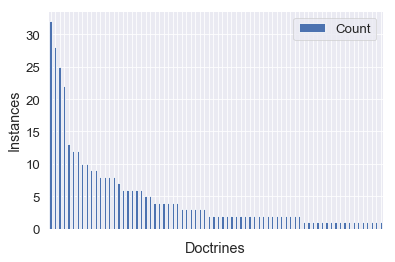

In [41]:
# See the long tail of low frequency doctrines
ax = instance_distributions.plot(kind='bar')
ax.set_xticklabels([])
ax.set_xlabel('Doctrines')
ax.set_ylabel('Instances')

In [40]:
fig = ax.get_figure()
fig.savefig('../thesis/data/figures/process-doctrine-instance-distribution.pdf')
print_figure_inclusion(
    '../figures/process-doctrine-instance-distribution',
    caption='Doctrine to instance proportions of all doctrines in the chapter.',
    label='fig:process:doctrine-instance-distributions')

\begin{figure}
\centering
\includegraphics[width=\linewidth]{data/figures/process-doctrine-instance-distribution.pdf}
\caption{Doctrine to instance proportions of all doctrines in the chapter.}
\label{fig:process:doctrine-instance-distributions}
\end{figure}


### Unique and shared doctrines


In [15]:
def count_unique_doctrines():
    q = ("MATCH (a:Author)--(t:Text)--(:Question)--(i:Instance)--(d:Doctrine) "
         "WHERE (i)--(:DissertationPart {chapter:3}) "
         "WITH collect(distinct a) as authors, d "
         "WHERE size(authors) = 1 "
         "UNWIND authors as author "
         "return count(distinct d) as cnt, author.name as name")
    return {d['name']: d['cnt'] for d in graph.run(q).data()}

# Example
unique = count_unique_doctrines()

In [16]:
def count_shared_doctrines(name):
    q = ("MATCH (a:Author)--(:Text)--(:Question)--(i1:Instance)--(d:Doctrine) "
         "WHERE (i1)--(:DissertationPart {chapter:3}) "
         "MATCH (d)--(i2:Instance)--(:Question)--(:Text)--(a2:Author) "
         "WHERE (a) <> (a2) "
         "AND (i2)--(:DissertationPart {chapter:3}) "
         "return count(distinct d) as cnt, a.name as name")
    return {d['name']: d['cnt'] for d in graph.run(q).data()}

# Example
shared = count_shared_doctrines('John of Jandun')

In [17]:
def unique_to_shared_proportion(name, unique_dict, shared_dict):
    unique = unique_dict.get(name, 0)
    shared = shared_dict.get(name, 0)
    try:
        return unique / (unique + shared)
    except ZeroDivisionError:
        return 0
    
# Example
unique_to_shared_proportion('John of Jandun', unique, shared)

0.4375

Now let's get the values of these for all the commentators and put them into a matrix.

In [18]:
def unique_shared_doctrines_all(authors, unique_dict, shared_dict):
    d = {}
    for a in authors:
        unique = unique_dict.get(a, 0)
        shared = shared_dict.get(a, 0)
        prop = unique_to_shared_proportion(a, unique_dict, shared_dict)
        
        d[a] = [unique, shared, unique + shared, round(prop, 2)]
    return d

# Example
m = unique_shared_doctrines_all(author_names, unique, shared)

Put this in a DataFrame and sort according to most unique.

In [19]:
uniqueness_df_orig = pd.DataFrame(m, index=['Unique', 'Shared', 'Sum', 'Proportion'])
uniqueness_df = uniqueness_df_orig.T.sort_values(by='Proportion', ascending=False)
uniqueness_df[['Unique', 'Shared', 'Sum']] = uniqueness_df[['Unique', 'Shared', 'Sum']].astype(int)
uniqueness_df

,Unique,Shared,Sum,Proportion
Anonymus Digby 55,6,4,10,0.60
John of Jandun,14,18,32,0.44
Radulphus Brito,7,21,28,0.25
Siger of Brabant,2,6,8,0.25
Anonymus Bazan,3,17,20,0.15
Anonymus Assisi,2,14,16,0.12
John Dinsdale,2,17,19,0.11
Simon of Faversham,1,13,14,0.07
Henric de la Wyle,1,15,16,0.06
Anonymus Vat. Lat. 2170 2,0,12,12,0.00


In [20]:
save_table(
    table=uniqueness_df.to_latex(),
    filename='../thesis/data/tables/process-unique-shared-doctrines.tex',
    label='tab:process:unique-shared-doctrines',
    caption='Unique, shared, total and proportion of unique and shared doctrines.'
)

Printed the following table to ../thesis/data/tables/process-unique-shared-doctrines.tex:
\\begin{table}
\centering
\begin{tabular}{lrrrr}
\toprule
{} &  Unique &  Shared &  Sum &  Proportion \\
\midrule
Anonymus Digby 55         &       6 &       4 &   10 &        0.60 \\
John of Jandun            &      14 &      18 &   32 &        0.44 \\
Radulphus Brito           &       7 &      21 &   28 &        0.25 \\
Siger of Brabant          &       2 &       6 &    8 &        0.25 \\
Anonymus Bazan            &       3 &      17 &   20 &        0.15 \\
Anonymus Assisi           &       2 &      14 &   16 &        0.12 \\
John Dinsdale             &       2 &      17 &   19 &        0.11 \\
Simon of Faversham        &       1 &      13 &   14 &        0.07 \\
Henric de la Wyle         &       1 &      15 &   16 &        0.06 \\
Anonymus Vat. Lat. 2170 2 &       0 &      12 &   12 &        0.00 \\
\bottomrule
\end{tabular}
\caption{Unique, shared, total and proportion of unique and shared doc

In [21]:
# The sums?
uniqueness_df[['Unique', 'Shared', 'Sum']].sum()

Unique     38
Shared    137
Sum       175
dtype: int64

Notice that these numbers are not identical to the sums above. A unique doctrine is a doctrine that has at least one instantiation by exactly one author (i.e. he may use it more than once), while a shared doctrine has at least one instantiation two or more authors. 

This means that the number is a combination of doctrines and instantiations, and is therefore not identical to the separate doctrine and instance sums above. Any correspondence between the two is coincidental.

In [22]:
# Statistical summary
uniqueness_df.describe()

,Unique,Shared,Sum,Proportion
count,10.000000,10.000000,10.00000,10.000000
mean,3.800000,13.700000,17.50000,0.205000
std,4.211096,5.292552,7.61942,0.187335
min,0.000000,4.000000,8.00000,0.000000
25%,1.250000,12.250000,12.50000,0.080000
50%,2.000000,14.500000,16.00000,0.135000
75%,5.250000,17.000000,19.75000,0.250000
max,14.000000,21.000000,32.00000,0.600000


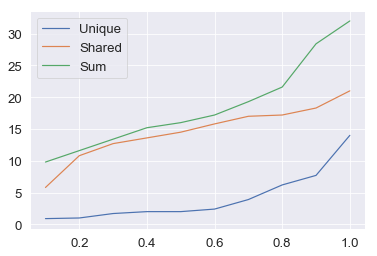

In [23]:
# Plot of the decentiles of unique, shared and sums
uniqueness_df[['Unique', 'Shared', 'Sum']].quantile(np.arange(0.1, 1.1, 0.1)).plot()

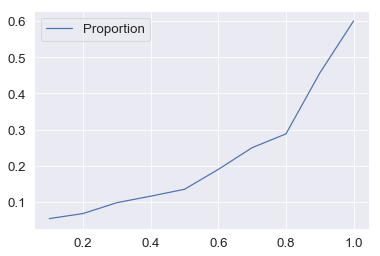

In [24]:
# Plot of the decentiles of the unique-shared proportions
uniqueness_df[['Proportion']].quantile(np.arange(0.1, 1.1, 0.1)).plot()

### Most popular determination and rationes doctrines

#### Rationes doctrines

In [25]:
q = ("match (d:Doctrine)-[:OF]-(i:Instance {type:'Conclusion'})--(:Question)--(:Text)--(a:Author)"
     "WHERE (i)--(:DissertationPart {chapter:3}) "
     "return distinct d.description as conclusions, collect(distinct a.name) as names, count(distinct i) as uses "
     "order by uses desc")
graph.run(q).to_table()

conclusions,names,uses
Self-knowledge through external species,"['Anonymus Vat. Lat. 2170 2', 'Anonymus Assisi', 'John Dinsdale', 'Henric de la Wyle', 'John of Jandun', 'Simon of Faversham']",6
The intellect is self-intelligible,"['Anonymus Bazan', 'Anonymus Digby 55', 'John of Jandun']",4
The intellect is intelligible,"['Anonymus Bazan', 'Anonymus Assisi', 'Radulphus Brito']",3
Agent intellect known through its products,"['Anonymus Bazan', 'Radulphus Brito']",2
The agent intellect is known like any other object,['Anonymus Bazan'],1
Internal experience of own mental faculties,['Radulphus Brito'],1
The intellect can observe its own activity,['Radulphus Brito'],1


#### Attacking doctrines

In [26]:
q = ("match (d:Doctrine)<-[:OF]-(i:Instance {type:'Negative ratio'})<-[:HAS]-(q:Question)--(:Text)--(a:Author) "
     "WHERE (i)--(:DissertationPart {chapter:3}) "
     "return distinct d.description as Description, count(distinct i) as Uses, count(distinct a) as User_count, collect(distinct a.name) as Users "
     "order by length(Users) desc")
popular_attacking = graph.run(q).to_data_frame()
popular_attacking


,Description,User_count,Users,Uses
0,Intellect not available to sense perception,5,"[Anonymus Bazan, Henric de la Wyle, John of Ja...",11
1,Identity of knower and known impossible,5,"[Anonymus Vat. Lat. 2170 2, Anonymus Assisi, J...",5
2,Similar to separate intelligences,5,"[Anonymus Vat. Lat. 2170 2, Anonymus Assisi, J...",5
3,Identity of mover and moved impossible,4,"[Anonymus Bazan, Anonymus Digby 55, John of Ja...",4
4,Knowing the act of the intellect risks infinit...,4,"[Anonymus Vat. Lat. 2170 2, John Dinsdale, Joh...",4
5,No abstraction of the intellect,3,"[Anonymus Bazan, John Dinsdale, Radulphus Brito]",3
6,Analogy with sense and sensation,3,"[Anonymus Bazan, John of Jandun, Radulphus Brito]",4
7,Intellect not its own proper object of knowledge,2,"[Anonymus Bazan, Radulphus Brito]",2
8,Self-knowledge by innate species,2,"[Henric de la Wyle, Simon of Faversham]",2
9,All intelligibles become intellects if intelle...,2,"[John Dinsdale, John of Jandun]",2


## High level clusters: Proportional distribution matrices

### Determinations

In [27]:
def proportion_shared_determination_doctrines(name):
    shared = graph.run(
        """
        MATCH (a1:Author {name:'%s'})-[:WROTE]->(:Text)-[:CONTAINS]->(:Question)-[:HAS]->(ia:Instance)--(d:Doctrine) 
        WHERE (ia)--(:DissertationPart {chapter:3}) 
        AND NOT EXISTS(ia.type) OR ia.type = 'Conclusion' 
        MATCH (a2:Author)-[:WROTE]->(:Text)-[:CONTAINS]->(:Question)-[:HAS]->(ib:Instance)--(d) 
        WHERE (ib)--(:DissertationPart {chapter:3}) 
        AND NOT EXISTS(ib.type) OR ib.type = 'Conclusion' 
        RETURN a2.name as name, count(distinct d) as shared
        """ % name
    ).data()
    shared = {d['name']: d['shared'] for d in shared}
    main = graph.run(
        "MATCH (a1:Author {name:'%s'})-[:WROTE]->(:Text)-[:CONTAINS]->(:Question)-[:HAS]->(i1:Instance)--(d1:Doctrine) "
        "WHERE (i1)--(:DissertationPart {chapter:3}) "         
        "AND NOT EXISTS(i1.type) OR i1.type = 'Conclusion' "
        "RETURN count(distinct d1)" % name
    ).evaluate()
    others = {}
    for d in shared:
        other = graph.run(
            "MATCH (a2:Author {name:'%s'})-[:WROTE]->(:Text)-[:CONTAINS]->(:Question)-[:HAS]->(i2:Instance)--(d2:Doctrine) "
            "WHERE (i2)--(:DissertationPart {chapter:3}) "         
            "AND NOT EXISTS(i2.type) OR i2.type = 'Conclusion' "
            "RETURN count(distinct d2)" % d
        ).evaluate()
        others[d] = shared[d] / (main + other - shared[d])
    return others
    
    # return {d['name']: d['proportion'] for d in graph.run(q).data()}

proportion_shared_determination_doctrines('John Dinsdale')

{'Siger of Brabant': 0.07142857142857142,
 'Anonymus Bazan': 0.13333333333333333,
 'Radulphus Brito': 0.2777777777777778,
 'Henric de la Wyle': 0.7777777777777778,
 'Anonymus Assisi': 0.4,
 'John Dinsdale': 1.0,
 'John of Jandun': 0.21052631578947367,
 'Anonymus Vat. Lat. 2170 2': 0.7777777777777778,
 'Simon of Faversham': 0.6363636363636364,
 'Anonymus Digby 55': 0.08333333333333333}

In [28]:
d = build_matrix(author_names, docfunc=proportion_shared_determination_doctrines)        

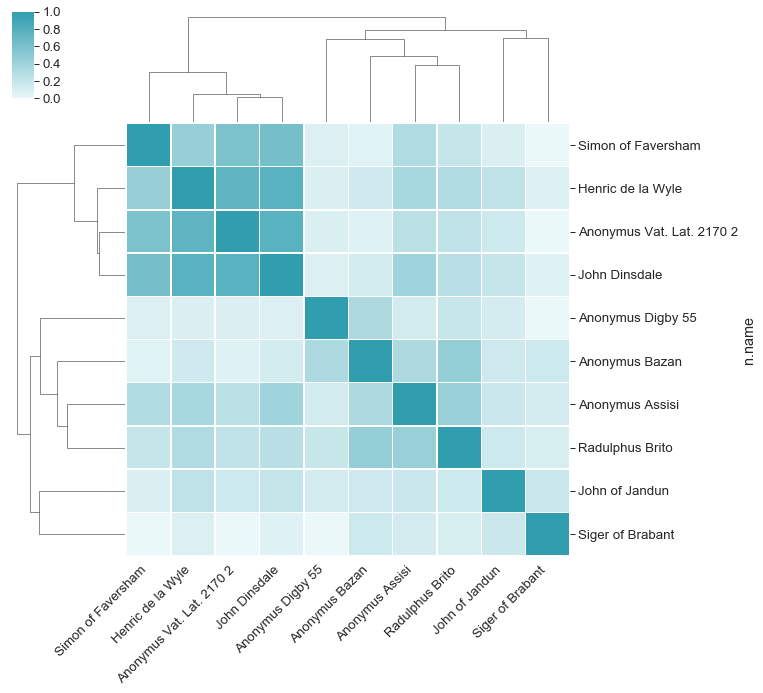

In [29]:
doctrine_frame = pd.DataFrame(d, index=author_names)

# Generate a custom diverging colormap
cmap = sns.light_palette((210, 90, 60), as_cmap=True, input="husl")

# Draw the heatmap with the mask and correct aspect ratio
plot = sns.clustermap(doctrine_frame, cmap=cmap, linewidths=.5, row_cluster=True)
for _, ax in enumerate(plot.fig.axes):
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, horizontalalignment='right')


In [30]:
plot.savefig('../thesis/data/figures/process-determ-proportional-clustermap.pdf')
print_figure_inclusion(
    '../figures/process-determ-proportional-clustermap',
    caption='Proportional clustermap of determination doctrines.',
    label='fig:process:determ:prop-clustermap')

\begin{figure}
\centering
\includegraphics[width=\linewidth]{data/figures/process-determ-proportional-clustermap.pdf}
\caption{Proportional clustermap of determination doctrines.}
\label{fig:process:determ:prop-clustermap}
\end{figure}


### Rationes

In [31]:
def proportion_shared_rationes_doctrines(name):
    shared = graph.run(
        """
        MATCH (a1:Author {name:'%s'})-[:WROTE]->(:Text)-[:CONTAINS]->(:Question)-[:HAS]->(ia:Instance)--(d:Doctrine) 
        WHERE (ia)--(:DissertationPart {chapter:3}) 
        AND (ia.type = 'Negative ratio' or ia.type = 'Refutation') 
        MATCH (a2:Author)-[:WROTE]->(:Text)-[:CONTAINS]->(:Question)-[:HAS]->(ib:Instance)--(d) 
        WHERE (ib)--(:DissertationPart {chapter:3}) 
        AND (ib.type = 'Negative ratio' or ib.type = 'Refutation')
        RETURN a2.name as name, count(distinct d) as shared
        """ % name
    ).data()
    shared = {d['name']: d['shared'] for d in shared}
    main = graph.run(
        "MATCH (a1:Author {name:'%s'})-[:WROTE]->(:Text)-[:CONTAINS]->(:Question)-[:HAS]->(i1:Instance)--(d1:Doctrine) "
        "WHERE (i1)--(:DissertationPart {chapter:3}) "         
        "AND (i1.type = 'Negative ratio' or i1.type = 'Refutation') "
        "RETURN count(distinct d1)" % name
    ).evaluate()
    others = {}
    for d in shared:
        other = graph.run(
            "MATCH (a2:Author {name:'%s'})-[:WROTE]->(:Text)-[:CONTAINS]->(:Question)-[:HAS]->(i2:Instance)--(d2:Doctrine) "
            "WHERE (i2)--(:DissertationPart {chapter:3}) "         
            "AND (i2.type = 'Negative ratio' or i2.type = 'Refutation') "
            "RETURN count(distinct d2)" % d
        ).evaluate()
        others[d] = shared[d] / (main + other - shared[d])
    return others

proportion_shared_rationes_doctrines('John of Jandun')

{'Siger of Brabant': 0.045454545454545456,
 'Anonymus Bazan': 0.25,
 'Radulphus Brito': 0.21875,
 'Henric de la Wyle': 0.034482758620689655,
 'John Dinsdale': 0.10344827586206896,
 'John of Jandun': 1.0,
 'Anonymus Vat. Lat. 2170 2': 0.04,
 'Simon of Faversham': 0.08,
 'Anonymus Digby 55': 0.07692307692307693}

In [32]:
rationes_matrix = build_matrix(author_names, docfunc=proportion_shared_rationes_doctrines)

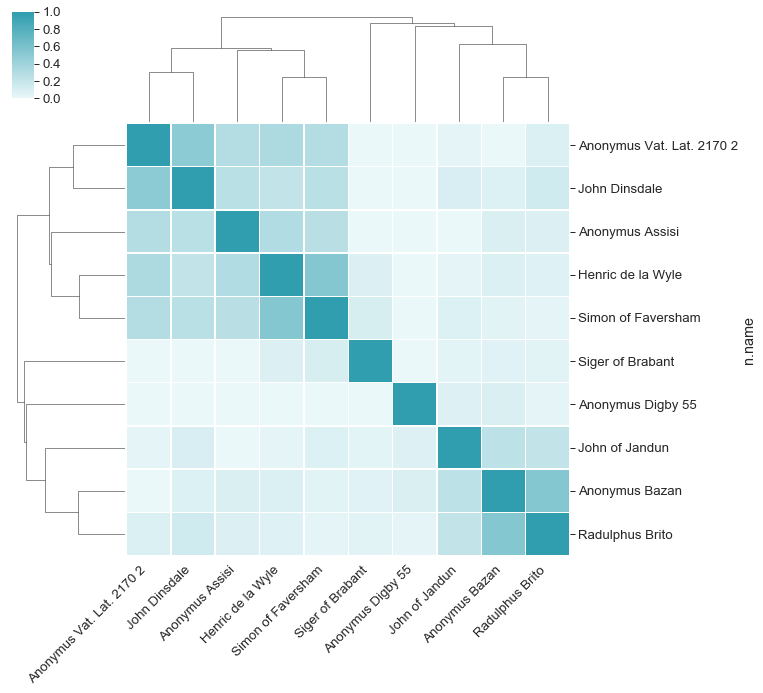

In [33]:
rationes_frame = pd.DataFrame(rationes_matrix, index=author_names)

# Generate a custom diverging colormap
cmap = sns.light_palette((210, 90, 60), as_cmap=True, input="husl")

# Draw the heatmap with the mask and correct aspect ratio
plot = sns.clustermap(rationes_frame, cmap=cmap, linewidths=.5, row_cluster=True)
for _, ax in enumerate(plot.fig.axes):
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, horizontalalignment='right')

In [34]:
plot.savefig('../thesis/data/figures/process-rationes-proportional-clustermap.pdf')
print_figure_inclusion(
    '../figures/process-rationes-proportional-clustermap',
    caption='Proportional clustermap of rationes doctrines.',
    label='fig:process:rationes:prop-clustermap')

\begin{figure}
\centering
\includegraphics[width=\linewidth]{data/figures/process-rationes-proportional-clustermap.pdf}
\caption{Proportional clustermap of rationes doctrines.}
\label{fig:process:rationes:prop-clustermap}
\end{figure}


### All doctrines

In [35]:
def proportion_shared_doctrines(name):
    shared_data = graph.run(
        "MATCH (a1:Author {name:'%s'})-[:WROTE]->(:Text)-[:CONTAINS]->(:Question)-[:HAS]->(ia:Instance)--(d:Doctrine) "
        "WHERE (ia)--(:DissertationPart {chapter:3}) "
        "MATCH (a2:Author)-[:WROTE]->(:Text)-[:CONTAINS]->(:Question)-[:HAS]->(ib:Instance)--(d) "
        "WHERE (ib)--(:DissertationPart {chapter:3}) "
        "RETURN a2.name as name, count(distinct d) as shared" % name
    ).data()
    shared_dict = {d['name']: d['shared'] for d in shared_data}
    proportional_dict = {}
    for other, shared in shared_dict.items():
        sum_start = graph.run(
            "MATCH (:Author {name:'%s'})-[:WROTE]->(:Text)-[:CONTAINS]->(:Question)-[:HAS]->(i1:Instance)--(d1:Doctrine) "
            "WHERE (i1)--(:DissertationPart {chapter:3}) "
            "RETURN count(distinct d1) " % name
        ).evaluate()
        sum_other = graph.run(
            "MATCH (:Author {name:'%s'})-[:WROTE]->(:Text)-[:CONTAINS]->(:Question)-[:HAS]->(i2:Instance)--(d2:Doctrine) "
            "WHERE (i2)--(:DissertationPart {chapter:3}) "
            "RETURN count(distinct d2) " % other
        ).evaluate()
        shared_dict[other] = shared / (sum_start + sum_other - shared)
    return shared_dict

dinsdale = proportion_shared_doctrines('John Dinsdale')
dinsdale

{'Siger of Brabant': 0.038461538461538464,
 'Anonymus Bazan': 0.14705882352941177,
 'Radulphus Brito': 0.23684210526315788,
 'Henric de la Wyle': 0.4,
 'Anonymus Assisi': 0.34615384615384615,
 'John of Jandun': 0.1590909090909091,
 'John Dinsdale': 1.0,
 'Anonymus Vat. Lat. 2170 2': 0.631578947368421,
 'Simon of Faversham': 0.375,
 'Anonymus Digby 55': 0.03571428571428571}

In [36]:
#Example table of dinsdale
dinsdale_df = pd.DataFrame(dinsdale, index=['Proportion']).round(2)
dinsdale_df.index.name = 'Name'
dinsdale_df = dinsdale_df.T.sort_values(ascending=False, by='Proportion')
dinsdale_df

Name,Proportion
John Dinsdale,1.00
Anonymus Vat. Lat. 2170 2,0.63
Henric de la Wyle,0.40
Simon of Faversham,0.38
Anonymus Assisi,0.35
Radulphus Brito,0.24
John of Jandun,0.16
Anonymus Bazan,0.15
Siger of Brabant,0.04
Anonymus Digby 55,0.04


In [37]:
save_table(
    filename='../thesis/data/tables/dinsdale-fingerprint.tex',
    table=dinsdale_df.to_latex(),
    caption='Relative distribution signature of all doctrines of John Dinsdale.',
    label='tab:process:signature-dinsdale'
)

Printed the following table to ../thesis/data/tables/dinsdale-fingerprint.tex:
\\begin{table}
\centering
\begin{tabular}{lr}
\toprule
Name &  Proportion \\
\midrule
John Dinsdale             &        1.00 \\
Anonymus Vat. Lat. 2170 2 &        0.63 \\
Henric de la Wyle         &        0.40 \\
Simon of Faversham        &        0.38 \\
Anonymus Assisi           &        0.35 \\
Radulphus Brito           &        0.24 \\
John of Jandun            &        0.16 \\
Anonymus Bazan            &        0.15 \\
Siger of Brabant          &        0.04 \\
Anonymus Digby 55         &        0.04 \\
\bottomrule
\end{tabular}
\caption{Relative distribution signature of all doctrines of John Dinsdale.}
\label{tab:process:signature-dinsdale}
\end{table}


In [38]:
all_matrix = build_matrix(author_names, docfunc=proportion_shared_doctrines)

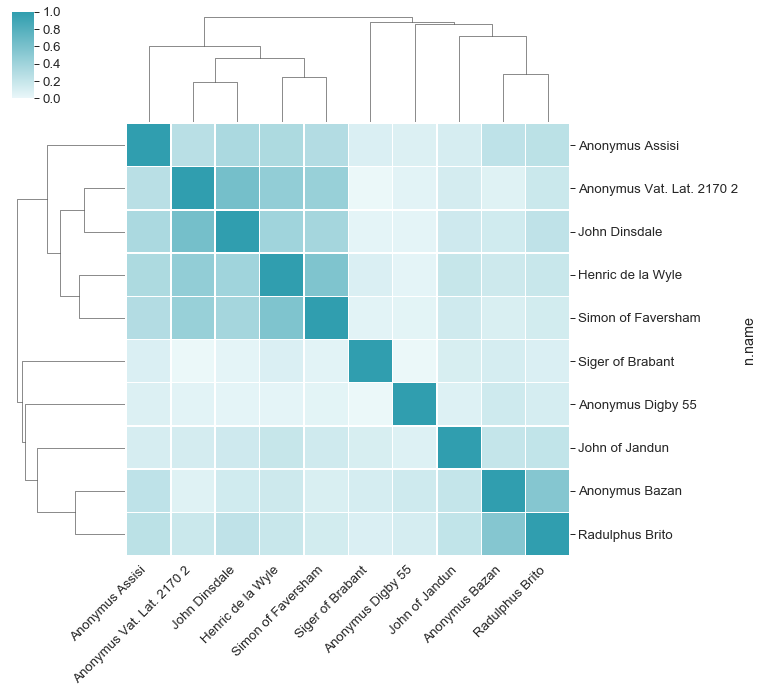

In [39]:
all_frame = pd.DataFrame(all_matrix, index=author_names)

# Generate a custom diverging colormap
cmap = sns.light_palette((210, 90, 60), as_cmap=True, input="husl")

# Draw the heatmap with the mask and correct aspect ratio
plot = sns.clustermap(all_frame, cmap=cmap, linewidths=.5, row_cluster=True)
for _, ax in enumerate(plot.fig.axes):
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, horizontalalignment='right')

In [40]:
plot.savefig('../thesis/data/figures/process-all-proportional-clustermap.pdf')
print_figure_inclusion(
    '../figures/process-all-proportional-clustermap',
    caption='Proportional clustermap of all doctrines.',
    label='fig:process:all:prop-clustermap')

\begin{figure}
\centering
\includegraphics[width=\linewidth]{data/figures/process-all-proportional-clustermap.pdf}
\caption{Proportional clustermap of all doctrines.}
\label{fig:process:all:prop-clustermap}
\end{figure}


Get a path of specific combinations
This matches supporting to a level of 8 nodes.
```
match (:Conclusion)-[:OF]->(dc:Doctrine)
call apoc.path.expand(dc, "<SUPPORTS,<SUPPORTS|<IMPLIES|OF>", "Instance|Doctrine", 1, 8) yield path as pp
return pp
```

# Create doctrinal matrix
Here we want to create a matrix table where it can be seen in more detail which doctrines each commentator uses. It is probably a good idea to distinguish between determination doctrines and rationes doctrines.

First we pull out a list of the names of the doctrines in determinations of each commentator.

## Determination doctrines

In [41]:
def determination_doctrines_of(name):
    q = ("MATCH (a:Author {name:'%s'})--(t:Text)--(q:Question)--(i:Instance)--(d:Doctrine) "
         "WHERE (not exists(i.type) or i.type = 'Conclusion') "
         "AND (i)--(:DissertationPart {chapter:3}) "
         "RETURN distinct d.label as Label, d.description as Doctrine " % name )
    docs = []
    for d in graph.run(q).data():
        if d['Label']:
            docs.append(', '.join(d['Label']) + ': ' + d['Doctrine'])
        else:
            docs.append(d['Doctrine'])
    return docs

# Example test
determination_doctrines_of("John of Jandun")

['P31: Perpetual self-knowledge of agent intellect not available to humans',
 'P37: Possible and agent intellect joined in constant knowledge',
 'P63: Agent intellect the most venerable object of knowledge',
 'P74, N21: Self-knowledge by innate species',
 'P23, N34: The intellect has essential self-knowledge',
 'P18: Self-knowledge different from the science of the soul',
 'P79: Essential self-knowledge results in no self-knowledge',
 'P20: Understanding a blocking activity',
 'P3: Substantial knowledge from accidents',
 'P2: Self-knowledge through external species',
 'P4: Possible intellect completely indeterminate before actualization by an external species',
 'P7: The intellect is self-intelligible',
 'P75: Concomitant higher-order understanding',
 'P67: The intellect is intelligible like any other thing']

Then we create a full list of all the doctrines in determinations.

In [42]:
def all_determination_doctrines():
    q = ("MATCH (i:Instance)--(d:Doctrine) "
         "WHERE (not exists(i.type) or i.type = 'Conclusion') "
         "AND (i)--(:DissertationPart {chapter:3}) "
         "RETURN distinct d.description as Doctrine, d.label as Label")
    docs = []
    for d in graph.run(q).data():
        if d['Label']:
            docs.append(', '.join(d['Label']) + ': ' + d['Doctrine'])
        else:
            docs.append(d['Doctrine'])
    return docs

all_determination_docs = all_determination_doctrines()

# Test output
all_determination_docs

['P13: Agent intellect known through its products',
 'P12: The intellect is intelligible',
 'P8: Intellect intelligble through external species',
 'P7: The intellect is self-intelligible',
 'P2: Self-knowledge through external species',
 'P14: Successive self-knowledge',
 'P44: Internal experience of own mental faculties',
 'P34: The intellect can observe its own activity',
 'P80: Superiority to sense-perception',
 'P5: An immaterial substance is self-reflexive',
 'P67: The intellect is intelligible like any other thing',
 'P23, N34: The intellect has essential self-knowledge',
 'P22: Identity of knower and known in immaterial substances',
 'P4: Possible intellect completely indeterminate before actualization by an external species',
 'P27: Analogy with vision: Only things visible in act can be perceived',
 'P26, N24: Intelligibility requires actuality',
 'P3: Substantial knowledge from accidents',
 'P11: Possible intellect similar to prime matter',
 'P10: Great chain of being and the 

Now for each author we register how many of the doctrines he ticks off and reads that into a matrix.

In [43]:
matrix = {}
for author in author_names:
    matrix[author] = []
    adocs = determination_doctrines_of(author)
    for doc in all_determination_docs:
        if doc in adocs:
            matrix[author].append(1)
        else:
            matrix[author].append(0)


determination_df = pd.DataFrame(matrix, index=all_determination_docs)
determination_df

,Anonymus Assisi,Anonymus Bazan,Anonymus Digby 55,Anonymus Vat. Lat. 2170 2,Henric de la Wyle,John Dinsdale,John of Jandun,Radulphus Brito,Siger of Brabant,Simon of Faversham
P13: Agent intellect known through its products,0,1,0,0,0,0,0,1,1,0
P12: The intellect is intelligible,1,1,0,0,0,0,0,1,0,0
P8: Intellect intelligble through external species,1,1,0,0,0,0,0,1,0,0
P7: The intellect is self-intelligible,0,1,1,0,0,0,1,1,0,0
P2: Self-knowledge through external species,1,1,1,1,1,1,1,1,0,1
P14: Successive self-knowledge,1,1,1,0,0,0,0,1,0,0
P44: Internal experience of own mental faculties,0,0,0,0,0,0,0,1,0,0
P34: The intellect can observe its own activity,0,0,0,0,0,0,0,1,0,0
P80: Superiority to sense-perception,0,0,0,0,0,0,0,1,0,0
P5: An immaterial substance is self-reflexive,1,0,0,1,1,1,0,1,0,1


In [44]:
sums = determination_df.sum().sort_values(ascending=False)
sums

Radulphus Brito              14
John of Jandun               14
Anonymus Assisi              12
Simon of Faversham            9
John Dinsdale                 9
Anonymus Bazan                8
Henric de la Wyle             7
Anonymus Vat. Lat. 2170 2     7
Siger of Brabant              6
Anonymus Digby 55             4
dtype: int64

What is the mean amount of doctrines?

In [45]:
determination_df.sum().mean()

9.0

### Popularity of arguments

In [46]:
determination_df.sum(axis=1).sort_values(ascending=False)

P2: Self-knowledge through external species                                                    9
P3: Substantial knowledge from accidents                                                       7
P4: Possible intellect completely indeterminate before actualization by an external species    7
P5: An immaterial substance is self-reflexive                                                  6
P11: Possible intellect similar to prime matter                                                6
P10: Great chain of being and the intellect                                                    4
P7: The intellect is self-intelligible                                                         4
P14: Successive self-knowledge                                                                 4
P18: Self-knowledge different from the science of the soul                                     4
P12: The intellect is intelligible                                                             3
P8: Intellect intelligble thro

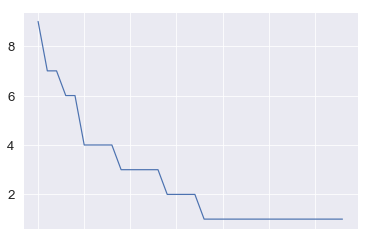

In [47]:
determination_df.sum(axis=1).sort_values(ascending=False).plot()

### Binary matrix cluster analysis
So what if we take the binary matrix representing the presence or absence of a doctrine and use that for clustering?
I have used this as an inspiration: https://stats.stackexchange.com/questions/222492/any-distance-measures-that-are-more-useful-for-binary-data-clustering.
As suggested in the post we use the Hamming metric for distance measuring, as that just counts the number of coordinates that differ. AS it is also mentioned in the scipy documentation it can therefore be used for boolean matrices (https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html).

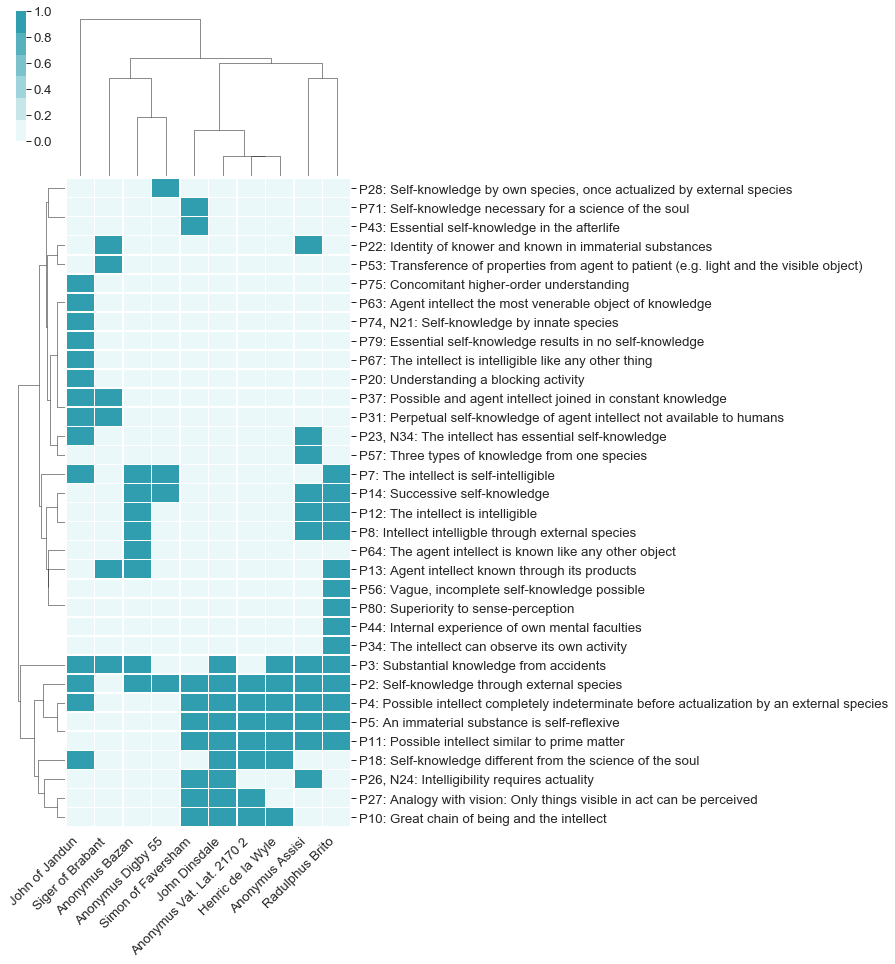

In [48]:
# Generate a custom diverging colormap
cmap = sns.light_palette((210, 90, 60), input="husl")

# Draw the heatmap with the mask and correct aspect ratio
plot = sns.clustermap(determination_df, cmap=cmap, linewidths=.5, figsize=(6, 15), row_cluster=True, metric='hamming')

for _, ax in enumerate(plot.fig.axes):
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, horizontalalignment='right')

In [49]:
plot.savefig('../thesis/data/figures/process-determination-binary-clustermap.pdf')
print_figure_inclusion(
    'process-determinations-binary-clustermap.pdf',
    caption='Binary doctrinal matrix of determination doctrines.',
    label='fig:process:determination:binary-clustermap')

\begin{figure}
\centering
\includegraphics[width=\linewidth]{data/figures/process-determinations-binary-clustermap.pdf}
\caption{Binary doctrinal matrix of determination doctrines.}
\label{fig:process:determination:binary-clustermap}
\end{figure}


## Rationes doctrines

In [50]:
def rationes_doctrines_of(name):
    q = ("MATCH (a:Author {name:'%s'})--(t:Text)--(q:Question)--(i:Instance)--(d:Doctrine) "
         "WHERE (i.type = 'Negative ratio' OR i.type = 'Refutation') "
         "AND (i)--(:DissertationPart {chapter:3}) "
         "RETURN distinct d.label as Label, d.description as Doctrine " % name )
    docs = []
    for d in graph.run(q).data():
        if d['Label']:
            docs.append(', '.join(d['Label']) + ': ' + d['Doctrine'])
        else:
            docs.append(d['Doctrine'])
    return docs

# Example test
rationes_doctrines_of("John of Jandun")

['P68, N4: Intellect not available to sense perception',
 'P70: The intellect can understand completely immaterial things',
 'P5: An immaterial substance is self-reflexive',
 'N12: Analogy with sense and sensation',
 'P2: Self-knowledge through external species',
 'N19: All intelligibles become intellects if intellect is intelligible',
 'P7: The intellect is self-intelligible',
 'N23: Material intelligibles cannot know themselves',
 'N37: Nothing can move itself (knowledge is being-moved)',
 'P1: Primary and secondary intelligibility',
 'N3: Identity of mover and moved impossible',
 'P66: Act and potency with different respects',
 'N20: No simultaneous act and potency',
 'P19: Bodily senses are not reflexive',
 'N31: Diversification of understanding according to object',
 'P61: Diversification only a problem with same mode of being',
 'P39: Multiple simultaneous objects of understanding is possible',
 'N11: Knowing the act of the intellect risks infinite regress',
 'N30: Multiple simul

Then we create a full list of all the doctrines in rationes.

In [51]:
def all_rationes_doctrines():
    q = ("MATCH (i:Instance)--(d:Doctrine) "
         "WHERE (i.type = 'Negative ratio' OR i.type = 'Refutation') "
         "AND (i)--(:DissertationPart {chapter:3}) "
         "RETURN distinct d.label as Label, d.description as Doctrine " )
    docs = []
    for d in graph.run(q).data():
        if d['Label']:
            docs.append(', '.join(d['Label']) + ': ' + d['Doctrine'])
        else:
            docs.append(d['Doctrine'])
    return docs

all_rationes_docs = all_rationes_doctrines()

# Test output
all_rationes_docs

['P34: The intellect can observe its own activity',
 'N12: Analogy with sense and sensation',
 'P19: Bodily senses are not reflexive',
 'N3: Identity of mover and moved impossible',
 'P12: The intellect is intelligible',
 'P41, N18: Intellect not its own proper object of knowledge',
 'P7: The intellect is self-intelligible',
 'P1: Primary and secondary intelligibility',
 'P44: Internal experience of own mental faculties',
 'N16: The possible intellect is not actualized',
 'P8: Intellect intelligble through external species',
 'P36: Only restriction of identity in physical movement',
 'P68, N4: Intellect not available to sense perception',
 'P42: Intellect is perceptible after actualization',
 'N11: Knowing the act of the intellect risks infinite regress',
 'N20: No simultaneous act and potency',
 'P66: Act and potency with different respects',
 'P29: Infinite regress not a problem in the intellect',
 'P52: Only physical movement requires difference between mover and moved',
 'N37: Noth

Now for each author we register how many of the doctrines he ticks off and reads that into a matrix.

In [52]:
matrix = {}
for author in author_names:
    matrix[author] = []
    adocs = rationes_doctrines_of(author)
    for doc in all_rationes_docs:
        if doc in adocs:
            matrix[author].append(1)
        else:
            matrix[author].append(0)


rationes_df = pd.DataFrame(matrix, index=all_rationes_docs)
rationes_df

,Anonymus Assisi,Anonymus Bazan,Anonymus Digby 55,Anonymus Vat. Lat. 2170 2,Henric de la Wyle,John Dinsdale,John of Jandun,Radulphus Brito,Siger of Brabant,Simon of Faversham
P34: The intellect can observe its own activity,0,0,0,0,0,0,0,1,0,0
N12: Analogy with sense and sensation,0,1,0,0,0,0,1,1,0,0
P19: Bodily senses are not reflexive,0,1,0,0,0,0,1,1,0,0
N3: Identity of mover and moved impossible,0,1,1,0,0,0,1,1,0,0
P12: The intellect is intelligible,0,1,0,0,0,0,0,1,0,0
"P41, N18: Intellect not its own proper object of knowledge",1,1,0,0,0,1,0,1,0,0
P7: The intellect is self-intelligible,0,1,1,0,0,0,1,0,0,0
P1: Primary and secondary intelligibility,0,1,0,0,0,0,1,1,0,0
P44: Internal experience of own mental faculties,0,0,0,0,0,0,0,1,0,0
N16: The possible intellect is not actualized,0,1,0,0,0,0,0,1,0,0


In [53]:
sums = rationes_df.sum().sort_values(ascending=False)
sums

John of Jandun               20
Radulphus Brito              19
Anonymus Bazan               15
John Dinsdale                12
Henric de la Wyle            10
Anonymus Digby 55             8
Simon of Faversham            7
Anonymus Assisi               7
Anonymus Vat. Lat. 2170 2     6
Siger of Brabant              3
dtype: int64

What is the mean amount of doctrines?

In [54]:
rationes_df.sum().mean()

10.7

### Popularity of arguments

In [55]:
rationes_df.sum(axis=1).sort_values(ascending=False)

P68, N4: Intellect not available to sense perception                                           6
P4: Possible intellect completely indeterminate before actualization by an external species    5
N5: Identity of knower and known impossible                                                    5
N7: Similar to separate intelligences                                                          5
N3: Identity of mover and moved impossible                                                     4
P41, N18: Intellect not its own proper object of knowledge                                     4
N11: Knowing the act of the intellect risks infinite regress                                   4
P8: Intellect intelligble through external species                                             4
P29: Infinite regress not a problem in the intellect                                           3
P7: The intellect is self-intelligible                                                         3
P19: Bodily senses are not ref

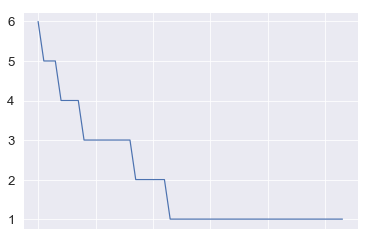

In [56]:
rationes_df.sum(axis=1).sort_values(ascending=False).plot()

### Binary matrix cluster analysis


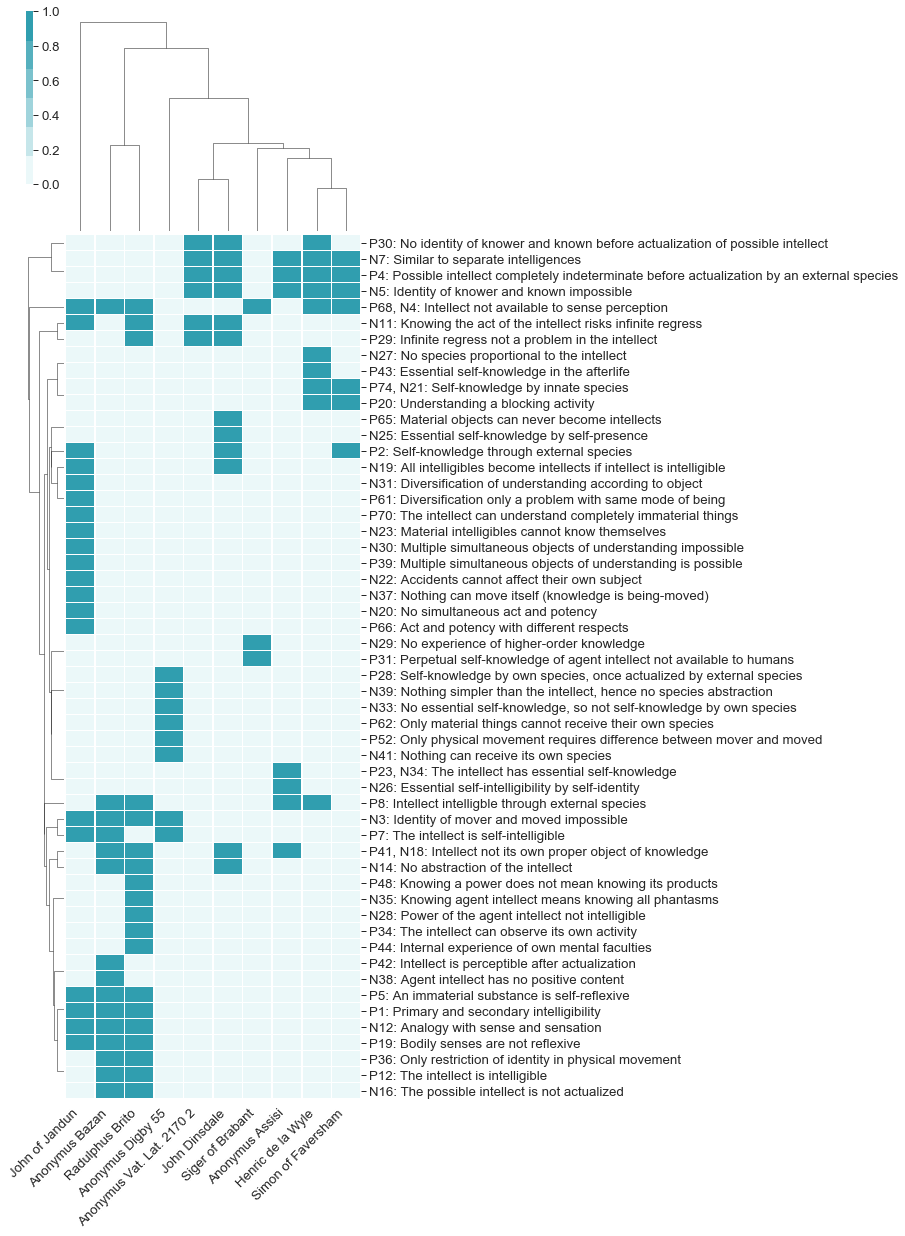

In [57]:
# Generate a custom diverging colormap
cmap = sns.light_palette((210, 90, 60), input="husl")

# Draw the heatmap with the mask and correct aspect ratio
plot = sns.clustermap(rationes_df, cmap=cmap, linewidths=.5, figsize=(6, 20), row_cluster=True, metric='hamming')

for _, ax in enumerate(plot.fig.axes):
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, horizontalalignment='right')

In [58]:
plot.savefig('../thesis/data/figures/process-rationes-binary-clustermap.pdf')
print_figure_inclusion(
    'process-rationes-binary-clustermap.pdf',
    caption='Binary doctrinal matrix of rationes doctrines.',
    label='fig:process:rationes:binary-clustermap')

\begin{figure}
\centering
\includegraphics[width=\linewidth]{data/figures/process-rationes-binary-clustermap.pdf}
\caption{Binary doctrinal matrix of rationes doctrines.}
\label{fig:process:rationes:binary-clustermap}
\end{figure}


# Quantifying centrality

Can we see whether there are some commentators who take up a central position in terms of how big a proportion of doctrines they contain?

Can we also sort them by how by a proportion of the most common doctrines they contain? Will there be any difference between such two measures?

In [59]:
q = ('MATCH (n:Author)--(:Text)--(:Question)--(:Instance)--(:DissertationPart {chapter:3})'
     'RETURN distinct n.name as Name, id(n) as ID ORDER BY n.name asc')
df = graph.run(q).to_data_frame()
author_names = df['Name']
df

,ID,Name
0,4,Anonymus Assisi
1,2,Anonymus Bazan
2,3,Anonymus Digby 55
3,1,Anonymus Vat. Lat. 2170 2
4,6,Henric de la Wyle
5,5,John Dinsdale
6,7,John of Jandun
7,8,Radulphus Brito
8,554,Siger of Brabant
9,10,Simon of Faversham


## Most common doctrines and who has most of them

Who has the highest proportion of the most common doctrines?

First we find the most popular doctrines. Let's take the upper quartile.

In [88]:
# Doctrine count instance distributions
q = ("MATCH (:DissertationPart {chapter:3})--(i:Instance)-[:OF|:IMPLIES]->(d:Doctrine) "
     "RETURN count(distinct i) as Count, d.description as Description, d.label as Label "
     "ORDER BY Count DESC")
print(q)
instance_distributions = graph.run(q).to_data_frame()
labels = []
for i in instance_distributions['Label']:
    if i:
        labels.append(', '.join(i))
    else:
        labels.append('')
instance_distributions['Label'] = labels

MATCH (:DissertationPart {chapter:3})--(i:Instance)-[:OF|:IMPLIES]->(d:Doctrine) RETURN count(distinct i) as Count, d.description as Description, d.label as Label ORDER BY Count DESC


In [89]:
popular_df = instance_distributions[instance_distributions['Count'] >= int(instance_distributions.quantile(0.67))]
save_table(
    filename='../thesis/data/tables/process-popular-doctrines.tex', 
    table=popular_df.to_latex(index=False),
    caption='Top one third of determination doctrines according to popularity.',
    label='tab:process:most-popular-doctrines')

Printed the following table to ../thesis/data/tables/process-popular-doctrines.tex:
\\begin{table}
\centering
\begin{tabular}{rll}
\toprule
 Count &                                        Description &     Label \\
\midrule
    13 &          An immaterial substance is self-reflexive &        P5 \\
    12 &              Primary and secondary intelligibility &        P1 \\
    12 &        Intellect not available to sense perception &   P68, N4 \\
    11 &            Self-knowledge through external species &        P2 \\
    11 &  Possible intellect completely indeterminate be... &        P4 \\
     9 &               Substantial knowledge from accidents &        P3 \\
     7 &     Intellect intelligble through external species &        P8 \\
     6 &             Great chain of being and the intellect &       P10 \\
     6 &         Possible intellect similar to prime matter &       P11 \\
     5 &                  Similar to separate intelligences &        N7 \\
     5 &            Identi

Then, to find out who presents most of these doctrines:
- Read all the doctrines of all the commentators into a dictionary.
- For each commentator, calculate how big a proportion of the most common doctrines he uses.

In [62]:
q = ("MATCH (a:Author)--(:Text)--(:Question)--(i:Instance)--(d:Doctrine) "
     "WHERE (i)--(:DissertationPart {chapter:3}) "
     "RETURN a.name as Name, collect(distinct d.description) as Doctrines")
commentator_doctrines = {d['Name']: set(d['Doctrines']) for d in graph.run(q).data()}

In [63]:
popular_proportion = {}
popular_set = set(popular_df['Description'])
for name, doctrines in commentator_doctrines.items():
    popular = len(popular_set & doctrines) / len(popular_set)
    proportion = len(popular_set & doctrines) / len(doctrines)
    average = (popular + proportion) / 2
    popular_proportion[name] = [popular, proportion, average]
popular_proportion

{'Siger of Brabant': [0.10344827586206896, 0.375, 0.23922413793103448],
 'Anonymus Bazan': [0.5517241379310345, 0.8, 0.6758620689655173],
 'Radulphus Brito': [0.7241379310344828, 0.75, 0.7370689655172413],
 'Henric de la Wyle': [0.4482758620689655, 0.8125, 0.6303879310344828],
 'Anonymus Assisi': [0.41379310344827586, 0.75, 0.5818965517241379],
 'John Dinsdale': [0.4482758620689655, 0.6842105263157895, 0.5662431941923776],
 'John of Jandun': [0.5517241379310345, 0.5, 0.5258620689655172],
 'Anonymus Vat. Lat. 2170 2': [0.3103448275862069, 0.75, 0.5301724137931034],
 'Simon of Faversham': [0.3448275862068966,
  0.7142857142857143,
  0.5295566502463054],
 'Anonymus Digby 55': [0.13793103448275862, 0.4, 0.2689655172413793]}

Now let's put the values into a DataFrame for presetational purposes.

In [64]:
popular_prop_df = pd.DataFrame(popular_proportion, index=['Popular', 'Concentration', 'Average'])
popular_prop_df.T.sort_values(by='Average', ascending=False).round(2)

,Popular,Concentration,Average
Radulphus Brito,0.72,0.75,0.74
Anonymus Bazan,0.55,0.80,0.68
Henric de la Wyle,0.45,0.81,0.63
Anonymus Assisi,0.41,0.75,0.58
John Dinsdale,0.45,0.68,0.57
Anonymus Vat. Lat. 2170 2,0.31,0.75,0.53
Simon of Faversham,0.34,0.71,0.53
John of Jandun,0.55,0.50,0.53
Anonymus Digby 55,0.14,0.40,0.27
Siger of Brabant,0.10,0.38,0.24


In [65]:
popular_prop_df.index.name = 'Name'
popular_props = popular_prop_df.T.sort_values(ascending=False, by='Average').round(2)
save_table(
    filename='../thesis/data/tables/process-popular-proportion.tex', 
    table=popular_props.to_latex(),
    caption='Proportion of most popular doctrines by commentator.',
    label='tab:process:most-popular-proportion')

Printed the following table to ../thesis/data/tables/process-popular-proportion.tex:
\\begin{table}
\centering
\begin{tabular}{lrrr}
\toprule
Name &  Popular &  Concentration &  Average \\
\midrule
Radulphus Brito           &     0.72 &           0.75 &     0.74 \\
Anonymus Bazan            &     0.55 &           0.80 &     0.68 \\
Henric de la Wyle         &     0.45 &           0.81 &     0.63 \\
Anonymus Assisi           &     0.41 &           0.75 &     0.58 \\
John Dinsdale             &     0.45 &           0.68 &     0.57 \\
Anonymus Vat. Lat. 2170 2 &     0.31 &           0.75 &     0.53 \\
Simon of Faversham        &     0.34 &           0.71 &     0.53 \\
John of Jandun            &     0.55 &           0.50 &     0.53 \\
Anonymus Digby 55         &     0.14 &           0.40 &     0.27 \\
Siger of Brabant          &     0.10 &           0.38 &     0.24 \\
\bottomrule
\end{tabular}
\caption{Proportion of most popular doctrines by commentator.}
\label{tab:process:most-popular-p

In [66]:
commentator_doctrines[popular_props.index[0]] & popular_set

{'Agent intellect known through its products',
 'An immaterial substance is self-reflexive',
 'Analogy with sense and sensation',
 'Bodily senses are not reflexive',
 'Identity of mover and moved impossible',
 'Intellect intelligble through external species',
 'Intellect not available to sense perception',
 'Intellect not its own proper object of knowledge',
 'Internal experience of own mental faculties',
 'Knowing the act of the intellect risks infinite regress',
 'No abstraction of the intellect',
 'Possible intellect completely indeterminate before actualization by an external species',
 'Possible intellect similar to prime matter',
 'Primary and secondary intelligibility',
 'Self-knowledge through external species',
 'Substantial knowledge from accidents',
 'Successive self-knowledge',
 'The intellect can observe its own activity',
 'The intellect is intelligible',
 'The intellect is self-intelligible',
 'The possible intellect is not actualized'}

In [67]:
commentator_doctrines[popular_props.index[1]] & popular_set

{'Agent intellect known through its products',
 'An immaterial substance is self-reflexive',
 'Analogy with sense and sensation',
 'Bodily senses are not reflexive',
 'Identity of mover and moved impossible',
 'Intellect intelligble through external species',
 'Intellect not available to sense perception',
 'Intellect not its own proper object of knowledge',
 'No abstraction of the intellect',
 'Primary and secondary intelligibility',
 'Self-knowledge through external species',
 'Substantial knowledge from accidents',
 'Successive self-knowledge',
 'The intellect is intelligible',
 'The intellect is self-intelligible',
 'The possible intellect is not actualized'}

In [68]:
commentator_doctrines[popular_props.index[2]] & popular_set

{'An immaterial substance is self-reflexive',
 'Great chain of being and the intellect',
 'Identity of knower and known impossible',
 'Intellect intelligble through external species',
 'Intellect not available to sense perception',
 'Possible intellect completely indeterminate before actualization by an external species',
 'Possible intellect similar to prime matter',
 'Self-knowledge by innate species',
 'Self-knowledge different from the science of the soul',
 'Self-knowledge through external species',
 'Similar to separate intelligences',
 'Substantial knowledge from accidents',
 'Understanding a blocking activity'}

## Scatterplot of uniqueness and popularity

As we have sketched the commentators along different axes of uniqueness/originality and to which degree they use commonly used doctrines, why not try putting them into a scatter plot?

In [69]:

a = popular_prop_df[0:1]
#a
b = uniqueness_df_orig[3:4]
a.index = ['Commonality']
b.index = ['Uniqueness']
unique_common_df = a.append(b, sort=True)
unique_common_df


,Anonymus Assisi,Anonymus Bazan,Anonymus Digby 55,Anonymus Vat. Lat. 2170 2,Henric de la Wyle,John Dinsdale,John of Jandun,Radulphus Brito,Siger of Brabant,Simon of Faversham
Commonality,0.413793,0.551724,0.137931,0.310345,0.448276,0.448276,0.551724,0.724138,0.103448,0.344828
Uniqueness,0.120000,0.150000,0.600000,0.000000,0.060000,0.110000,0.440000,0.250000,0.250000,0.070000


In [70]:
# Who have identical values?
d = {}
udf = unique_common_df.T
for name in udf.index:
    
    others = udf.index[
        (udf['Uniqueness'] == udf.loc[name]['Uniqueness']) 
        & (udf['Commonality'] == udf.loc[name]['Commonality'])
        &~ (udf.index == name)].tolist()
    if others:
        d[name + ', ' + ''.join(others)] = udf.loc[name]
    else:
        d[name] = udf.loc[name]
scatter_df = pd.DataFrame(d).T.drop_duplicates().reset_index()
scatter_df.columns = ['Names', 'Commonality', 'Uniqueness']
scatter_df

,Names,Commonality,Uniqueness
0,Anonymus Assisi,0.413793,0.12
1,Anonymus Bazan,0.551724,0.15
2,Anonymus Digby 55,0.137931,0.60
3,Anonymus Vat. Lat. 2170 2,0.310345,0.00
4,Henric de la Wyle,0.448276,0.06
5,John Dinsdale,0.448276,0.11
6,John of Jandun,0.551724,0.44
7,Radulphus Brito,0.724138,0.25
8,Siger of Brabant,0.103448,0.25
9,Simon of Faversham,0.344828,0.07


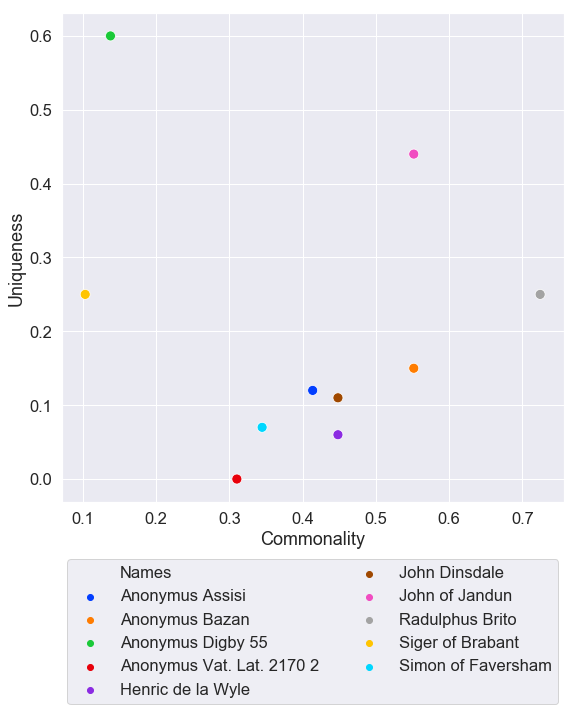

In [71]:
sns.set_context("notebook", font_scale=1.5)
f, ax = plt.subplots(1, figsize=(9, 9))
cmap = sns.color_palette('bright', len(scatter_df['Names']))
sns.scatterplot(x="Commonality", y="Uniqueness", hue="Names", data=scatter_df, s=100, palette=cmap)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

In [72]:
f.savefig('../thesis/data/figures/process-commonality-uniqueness-scatter.pdf', bbox_inches="tight")
print_figure_inclusion(
    'process-commonality-uniqueness-scatter.pdf',
    caption='Scatter plot of uniqueness and commonality of commentators.',
    label='fig:process:scatter-uniquness-commonality')

\begin{figure}
\centering
\includegraphics[width=\linewidth]{data/figures/process-commonality-uniqueness-scatter.pdf}
\caption{Scatter plot of uniqueness and commonality of commentators.}
\label{fig:process:scatter-uniquness-commonality}
\end{figure}


## One-sided commonality

Now, let's look at the data in the more one sided perspective of how big a proportion of the material of one commentator is also to be found in the others (regardless of their shared sum of material). So this is the uni-directional, non-symmetric relation. 

This can be described by the metaphor or "outgoing" material, as it lists how much of the doctrines of the starting commentator (`name`) are present in any other commentator.

The hypothesis is that this can be used to investigate which commentators have material that is also present in a high proportion of the other commentators (regardless of how much unique material they might have).

In [73]:
def corpus_count_doctrines():
    """
    Return the number of doctrines in the corpus.
    """
    q = ("MATCH (corpus:Doctrine)--(i)--(:DissertationPart {chapter:3}) RETURN count(distinct corpus) as count ")
    return graph.run(q).evaluate()


corpus_count = corpus_count_doctrines()

In [74]:
distributions = graph.run("match (a:Author)--(:Text)--(:Question)--(i:Instance)--(d:Doctrine) "
                          "WHERE (i)--(:DissertationPart {chapter:3}) "
                          "return count(distinct d) as cnt, a.name order by cnt desc").to_data_frame()
distributions.describe()

,cnt
count,10.00000
mean,17.50000
std,7.61942
min,8.00000
25%,12.50000
50%,16.00000
75%,19.75000
max,32.00000


In [75]:
def outgoing_shared_material(name):
    """
    Return a dictionary of how big a proportion 
    of his doctrines the searched commentator 
    shares with all the others.
    """
    q = ("MATCH (a1:Author {name:'%s'})--(:Text)--(:Question)--(i1:Instance)--(shared:Doctrine)--(i2:Instance)--(:Question)--(:Text)--(a2:Author)  "
         "WHERE (a1) <> (a2) "
         "AND (i1)--(:DissertationPart {chapter:3}) AND (i2)--(:DissertationPart {chapter:3}) "
         "MATCH (a1)--(:Text)--(:Question)--(i3:Instance)--(own:Doctrine) " 
         "WHERE (i3)--(:DissertationPart {chapter:3}) "
         "RETURN a2.name as name, count(distinct shared) as shared, count(distinct own) as own " % name)
    return {r['name']:  r['shared'] / r['own'] for r in graph.run(q).data()}

unidir_single = outgoing_shared_material('Anonymus Vat. Lat. 2170 2')
unidir_single

{'Anonymus Bazan': 0.16666666666666666,
 'Radulphus Brito': 0.5,
 'Henric de la Wyle': 0.75,
 'Anonymus Assisi': 0.5,
 'John Dinsdale': 1.0,
 'John of Jandun': 0.4166666666666667,
 'Simon of Faversham': 0.6666666666666666,
 'Anonymus Digby 55': 0.08333333333333333}

This function normalizes the values against the proportion of doctrines of the author compared to the full corpus. This results in much lower values than the absolute proportions, but corrects for the inaccuracy that rises when the number of doctrines of the author is far from the corpus average.

### Uni-directional overlap in full matrix

This shows how big a proportion of the doctrines of one commentator are also to be found in each of the others. 

This is not a symmetrical relation. 

This will show much much of the material of the column commnentator (X) is present in the others (Y). This only shows how big a proportion of the material (X) is also found in each of the others (Y). It thus does not show how close the two are to each other but merely how close the X is to Y.

Now let's try to build a matrix of those values for all the commentators. By default each column (X) will contain the array of results from the above function. 


In [76]:
uni_rel = build_matrix(author_names, docfunc=outgoing_shared_material)
matrix = pd.DataFrame(uni_rel, index=author_names)
matrix

,Anonymus Assisi,Anonymus Bazan,Anonymus Digby 55,Anonymus Vat. Lat. 2170 2,Henric de la Wyle,John Dinsdale,John of Jandun,Radulphus Brito,Siger of Brabant,Simon of Faversham
Name,,,,,,,,,,
Anonymus Assisi,0.0000,0.35,0.2,0.500000,0.5000,0.473684,0.15625,0.321429,0.250,0.500000
Anonymus Bazan,0.4375,0.00,0.4,0.166667,0.3125,0.263158,0.28125,0.607143,0.375,0.214286
Anonymus Digby 55,0.1250,0.20,0.0,0.083333,0.0625,0.052632,0.09375,0.142857,0.000,0.071429
Anonymus Vat. Lat. 2170 2,0.3750,0.10,0.1,0.000000,0.5625,0.631579,0.15625,0.214286,0.000,0.571429
Henric de la Wyle,0.5000,0.25,0.1,0.750000,0.0000,0.526316,0.25000,0.250000,0.250,0.785714
John Dinsdale,0.5625,0.25,0.1,1.000000,0.6250,0.000000,0.21875,0.321429,0.125,0.642857
John of Jandun,0.3125,0.45,0.3,0.416667,0.5000,0.368421,0.00000,0.392857,0.500,0.428571
Radulphus Brito,0.5625,0.85,0.4,0.500000,0.4375,0.473684,0.34375,0.000000,0.375,0.357143
Siger of Brabant,0.1250,0.15,0.0,0.000000,0.1250,0.052632,0.12500,0.107143,0.000,0.071429


As we use both the values of the columns and rows, we just copy those two transformations of the matrix into two variables.

The difference is the following: 
- The `columns` contains what can be thought of (inaccurately) as outgoing proportions. This will show how much of the material of the column commnentator (X) is present in the others (Y).
- The `rows` contains what can be thought of (inaccurately) as ingoing proportions. This will show how much of the material of the column commentator (X) that is identical with the total doctrines of the row commentator (Y).

In [77]:
cols = matrix
rows = matrix.T

#### Single author proportions

Now with this matrix we can get any of the columns to see the data on that commentator.

In [78]:
cols['John of Jandun'].sort_values(ascending=False)

Name
Radulphus Brito              0.34375
Anonymus Bazan               0.28125
Henric de la Wyle            0.25000
John Dinsdale                0.21875
Simon of Faversham           0.18750
Anonymus Vat. Lat. 2170 2    0.15625
Anonymus Assisi              0.15625
Siger of Brabant             0.12500
Anonymus Digby 55            0.09375
John of Jandun               0.00000
Name: John of Jandun, dtype: float64

This for example shows how big a proportion of Jandun's doctrines are also used by e.g. Brito, Bazan and Wyle (39%, 27%, and 23% as of this writing). 

#### Concentration factor

If we calculate the mean of each of those columns we get a single value for how strong a tendency there is for the doctrines of an author to also be present in other authors.

In other words, this is an indication of how big a proportion of the doctrines of each column commentator other commentators use. 

This means that reading the text of a commentator with a high concetration score, the reader is more likely to read doctrines that are also present in other texts.

In [79]:
concentration = cols.mean().sort_values(ascending=False).round(2)

In [80]:
concentration

Anonymus Vat. Lat. 2170 2    0.41
Henric de la Wyle            0.38
Simon of Faversham           0.36
Anonymus Assisi              0.34
John Dinsdale                0.33
Anonymus Bazan               0.27
Radulphus Brito              0.25
Siger of Brabant             0.20
John of Jandun               0.18
Anonymus Digby 55            0.17
dtype: float64

In [81]:
save_table(
    filename='../thesis/data/tables/process-mean-concentration.tex', 
    table=concentration.to_frame('Proportion').to_latex(),
    caption='Standardized mean concentration factors.',
    label='tab:process:mean-concentration-factor')

Printed the following table to ../thesis/data/tables/process-mean-concentration.tex:
\\begin{table}
\centering
\begin{tabular}{lr}
\toprule
{} &  Proportion \\
\midrule
Anonymus Vat. Lat. 2170 2 &        0.41 \\
Henric de la Wyle         &        0.38 \\
Simon of Faversham        &        0.36 \\
Anonymus Assisi           &        0.34 \\
John Dinsdale             &        0.33 \\
Anonymus Bazan            &        0.27 \\
Radulphus Brito           &        0.25 \\
Siger of Brabant          &        0.20 \\
John of Jandun            &        0.18 \\
Anonymus Digby 55         &        0.17 \\
\bottomrule
\end{tabular}
\caption{Standardized mean concentration factors.}
\label{tab:process:mean-concentration-factor}
\end{table}


Let's collect the two measurements into one and calculate an average.

In [82]:
exemplary = pd.DataFrame(popular_prop_df.T['Average'])
exemplary['Concentration'] = concentration
exemplary.columns = ['Common doctrines', 'Concentration']
exemplary['Average'] = (exemplary['Common doctrines'] + exemplary['Concentration']) / 2
exemplary = exemplary.sort_values(by='Average', ascending=False).round(2)
exemplary

,Common doctrines,Concentration,Average
Henric de la Wyle,0.63,0.38,0.51
Radulphus Brito,0.74,0.25,0.49
Anonymus Bazan,0.68,0.27,0.47
Anonymus Vat. Lat. 2170 2,0.53,0.41,0.47
Anonymus Assisi,0.58,0.34,0.46
John Dinsdale,0.57,0.33,0.45
Simon of Faversham,0.53,0.36,0.44
John of Jandun,0.53,0.18,0.35
Siger of Brabant,0.24,0.20,0.22
Anonymus Digby 55,0.27,0.17,0.22


In [83]:
save_table(
    filename='../thesis/data/tables/central-commentators.tex', 
    table=exemplary.to_latex(),
    caption='Proportions of popular doctrines, concentration indices, and the averages.',
    label='tab:process:central-commentators')

Printed the following table to ../thesis/data/tables/central-commentators.tex:
\\begin{table}
\centering
\begin{tabular}{lrrr}
\toprule
{} &  Common doctrines &  Concentration &  Average \\
\midrule
Henric de la Wyle         &              0.63 &           0.38 &     0.51 \\
Radulphus Brito           &              0.74 &           0.25 &     0.49 \\
Anonymus Bazan            &              0.68 &           0.27 &     0.47 \\
Anonymus Vat. Lat. 2170 2 &              0.53 &           0.41 &     0.47 \\
Anonymus Assisi           &              0.58 &           0.34 &     0.46 \\
John Dinsdale             &              0.57 &           0.33 &     0.45 \\
Simon of Faversham        &              0.53 &           0.36 &     0.44 \\
John of Jandun            &              0.53 &           0.18 &     0.35 \\
Siger of Brabant          &              0.24 &           0.20 &     0.22 \\
Anonymus Digby 55         &              0.27 &           0.17 &     0.22 \\
\bottomrule
\end{tabular}
\capt

### Who have high out-going overlap?

Now we can also take the max value of each of column in the recipiency matrix to reveal whether there are some commentators who have a very high out-going overlap, i.e. what the highest outgoing value this commentator has.

In [84]:
max_values_outgoing = pd.DataFrame(cols.max().sort_values(ascending=False), columns=['Value']).round(2)
col = {name: ', '.join(cols.index[cols[name] == cols[name].max()].tolist()) for name in cols.index}
max_values_outgoing['Commentator(s)'] = pd.Series(col)
max_values_outgoing

,Value,Commentator(s)
Anonymus Vat. Lat. 2170 2,1.00,John Dinsdale
Anonymus Bazan,0.85,Radulphus Brito
Simon of Faversham,0.79,Henric de la Wyle
Henric de la Wyle,0.69,Simon of Faversham
John Dinsdale,0.63,Anonymus Vat. Lat. 2170 2
Radulphus Brito,0.61,Anonymus Bazan
Anonymus Assisi,0.56,"John Dinsdale, Radulphus Brito"
Siger of Brabant,0.50,John of Jandun
Anonymus Digby 55,0.40,"Anonymus Bazan, Radulphus Brito"
John of Jandun,0.34,Radulphus Brito


This may be interesting to give hints about possible inheritance or inspiration.

# Playground and scratchpad